# Importing Libraries

In [ ]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import joblib
import pickle

# Time series libraries
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet

# Deep Learning
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# XGBoost
import xgboost as xgb

# Sklearn utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Suppress warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

All libraries imported successfully!
Pandas version: 2.2.2
NumPy version: 2.0.2


# Data Preprocessing and Cleaning

In [ ]:
# Load the dataset

file_path = 'air_project_data/air_quality_data.csv'

df = pd.read_csv(file_path)

print("="*60)
print("DATASET LOADED SUCCESSFULLY")
print("="*60)
print(f"\nDataset Shape: {df.shape}")
print(f"Number of Rows: {df.shape[0]}")
print(f"Number of Columns: {df.shape[1]}")
print("\n" + "="*60)
print("FIRST FEW ROWS")
print("="*60)
print(df.head(10))
print("\n" + "="*60)
print("DATASET INFO")
print("="*60)
df.info()
print("\n" + "="*60)
print("COLUMN NAMES")
print("="*60)
print(df.columns.tolist())

DATASET LOADED SUCCESSFULLY

Dataset Shape: (29531, 16)
Number of Rows: 29531
Number of Columns: 16

FIRST FEW ROWS
        City        Date  PM2.5  PM10      NO    NO2     NOx  NH3      CO  \
0  Ahmedabad  2015-01-01    NaN   NaN    0.92  18.22   17.15  NaN    0.92   
1  Ahmedabad  2015-01-02    NaN   NaN    0.97  15.69   16.46  NaN    0.97   
2  Ahmedabad  2015-01-03    NaN   NaN   17.40  19.30   29.70  NaN   17.40   
3  Ahmedabad  2015-01-04    NaN   NaN    1.70  18.48   17.97  NaN    1.70   
4  Ahmedabad  2015-01-05    NaN   NaN   22.10  21.42   37.76  NaN   22.10   
5  Ahmedabad  2015-01-06    NaN   NaN   45.41  38.48   81.50  NaN   45.41   
6  Ahmedabad  2015-01-07    NaN   NaN  112.16  40.62  130.77  NaN  112.16   
7  Ahmedabad  2015-01-08    NaN   NaN   80.87  36.74   96.75  NaN   80.87   
8  Ahmedabad  2015-01-09    NaN   NaN   29.16  31.00   48.00  NaN   29.16   
9  Ahmedabad  2015-01-10    NaN   NaN     NaN   7.04    0.00  NaN     NaN   

     SO2      O3  Benzene  Toluene  

**Analyzing Data Quality Issues like missing values, duplicate rows, data types, negative values etc;**

In [ ]:
# Analyze data quality issues
print("="*60)
print("DATA QUALITY ASSESSMENT")
print("="*60)

# Missing values
print("\n1. MISSING VALUES:")
print("-" * 40)
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing_Count': missing_values.values,
    'Missing_Percentage': missing_percent.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
print(missing_df.to_string(index=False))

# Duplicate rows
print(f"\n2. DUPLICATE ROWS: {df.duplicated().sum()}")

# Data types
print("\n3. DATA TYPES:")
print("-" * 40)
print(df.dtypes)

# Basic statistics
print("\n4. BASIC STATISTICS:")
print("-" * 40)
print(df.describe())

# Check for negative values in pollution data
print("\n5. CHECKING FOR NEGATIVE VALUES:")
print("-" * 40)
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    negative_count = (df[col] < 0).sum()
    if negative_count > 0:
        print(f"{col}: {negative_count} negative values found")
    else:
       print(f"{col}: No negative values found.")

DATA QUALITY ASSESSMENT

1. MISSING VALUES:
----------------------------------------
    Column  Missing_Count  Missing_Percentage
    Xylene          18109           61.322001
      PM10          11140           37.723071
       NH3          10328           34.973418
   Toluene           8041           27.229014
   Benzene           5623           19.041008
       AQI           4681           15.851139
AQI_Bucket           4681           15.851139
     PM2.5           4598           15.570079
       NOx           4185           14.171549
        O3           4022           13.619586
       SO2           3854           13.050692
       NO2           3585           12.139785
        NO           3582           12.129626
        CO           2059            6.972334

2. DUPLICATE ROWS: 0

3. DATA TYPES:
----------------------------------------
City           object
Date           object
PM2.5         float64
PM10          float64
NO            float64
NO2           float64
NOx           

**Handling Missing Values**

In [ ]:
# Create a copy for cleaning
df_clean = df.copy()

print("="*60)
print("DATA CLEANING - HANDLING MISSING VALUES")
print("="*60)

# Identify date/time column (common names)
date_columns = [col for col in df_clean.columns if any(x in col.lower() for x in ['date', 'time', 'datetime', 'timestamp'])]
print(f"\nIdentified date columns: {date_columns}")

# Convert date column to datetime
if date_columns:
    date_col = date_columns[0]
    df_clean[date_col] = pd.to_datetime(df_clean[date_col], errors='coerce')
    print(f"Converted '{date_col}' to datetime format")

    # Sort by date
    df_clean = df_clean.sort_values(date_col)
    print(f"Data sorted by {date_col}")

# Strategy for handling missing values
numeric_columns = df_clean.select_dtypes(include=[np.number]).columns

print("\nHandling missing values:")
for col in numeric_columns:
    missing_count = df_clean[col].isnull().sum()
    if missing_count > 0:
        # Use forward fill then backward fill for time series data
        df_clean[col] = df_clean[col].fillna(method='ffill').fillna(method='bfill')

        # If still missing, use median
        if df_clean[col].isnull().sum() > 0:
            df_clean[col] = df_clean[col].fillna(df_clean[col].median())

        print(f"  {col}: Filled {missing_count} missing values")

print(f"\nRemaining missing values: {df_clean.isnull().sum().sum()}")

DATA CLEANING - HANDLING MISSING VALUES

Identified date columns: ['Date']
Converted 'Date' to datetime format
Data sorted by Date

Handling missing values:
  PM2.5: Filled 4598 missing values
  PM10: Filled 11140 missing values
  NO: Filled 3582 missing values
  NO2: Filled 3585 missing values
  NOx: Filled 4185 missing values
  NH3: Filled 10328 missing values
  CO: Filled 2059 missing values
  SO2: Filled 3854 missing values
  O3: Filled 4022 missing values
  Benzene: Filled 5623 missing values
  Toluene: Filled 8041 missing values
  Xylene: Filled 18109 missing values
  AQI: Filled 4681 missing values

Remaining missing values: 4681


In [ ]:
print("="*60)
print("FEATURE ENGINEERING")
print("="*60)

# Identify date column
date_col = [col for col in df_clean.columns if any(x in col.lower() for x in ['date', 'time', 'datetime', 'timestamp'])][0]

# Extract time-based features
df_clean['year'] = df_clean[date_col].dt.year
df_clean['month'] = df_clean[date_col].dt.month
df_clean['day'] = df_clean[date_col].dt.day
df_clean['dayofweek'] = df_clean[date_col].dt.dayofweek
df_clean['quarter'] = df_clean[date_col].dt.quarter
df_clean['is_weekend'] = (df_clean['dayofweek'] >= 5).astype(int)

print("Time-based features created:")
print("  - year, month, day")
print("  - dayofweek (0=Monday, 6=Sunday)")
print("  - quarter")
print("  - is_weekend")

# Create lag features if AQI column exists
aqi_cols = [col for col in df_clean.columns if 'aqi' in col.lower()]

if aqi_cols:
    aqi_col = aqi_cols[0]
    print(f"\nCreating lag features for {aqi_col}:")

    for lag in [1, 7, 30]:
        df_clean[f'{aqi_col}_lag_{lag}'] = df_clean[aqi_col].shift(lag)
        print(f"  - {aqi_col}_lag_{lag}")

    # Create rolling mean features
    for window in [7, 14, 30]:
        df_clean[f'{aqi_col}_rolling_mean_{window}'] = df_clean[aqi_col].rolling(window=window).mean()
        print(f"  - {aqi_col}_rolling_mean_{window}")

# Drop rows with NaN created by lag/rolling features
df_clean = df_clean.dropna()

print(f"\nFinal shape after feature engineering: {df_clean.shape}")

FEATURE ENGINEERING
Time-based features created:
  - year, month, day
  - dayofweek (0=Monday, 6=Sunday)
  - quarter
  - is_weekend

Creating lag features for AQI:
  - AQI_lag_1
  - AQI_lag_7
  - AQI_lag_30
  - AQI_rolling_mean_7
  - AQI_rolling_mean_14
  - AQI_rolling_mean_30

Final shape after feature engineering: (24845, 28)


**Saving the cleaned Dataset**

In [ ]:
# Save cleaned dataset
output_path = 'air_project_data/cleaned_air_quality_data.csv'
df_clean.to_csv(output_path, index=False)

print("="*60)
print("CLEANED DATASET SAVED")
print("="*60)
print(f"File saved to: {output_path}")
print(f"Shape: {df_clean.shape}")
print(f"\nCleaning Summary:")
print(f"  - Original rows: {df.shape[0]}")
print(f"  - Cleaned rows: {df_clean.shape[0]}")
print(f"  - Rows removed: {df.shape[0] - df_clean.shape[0]}")
print(f"  - Columns: {df_clean.shape[1]}")

CLEANED DATASET SAVED
File saved to: air_project/cleaned_air_quality_data.csv
Shape: (24845, 28)

Cleaning Summary:
  - Original rows: 29531
  - Cleaned rows: 24845
  - Rows removed: 4686
  - Columns: 28


# Exploratory Data Analysis (EDA)

EXPLORATORY DATA ANALYSIS


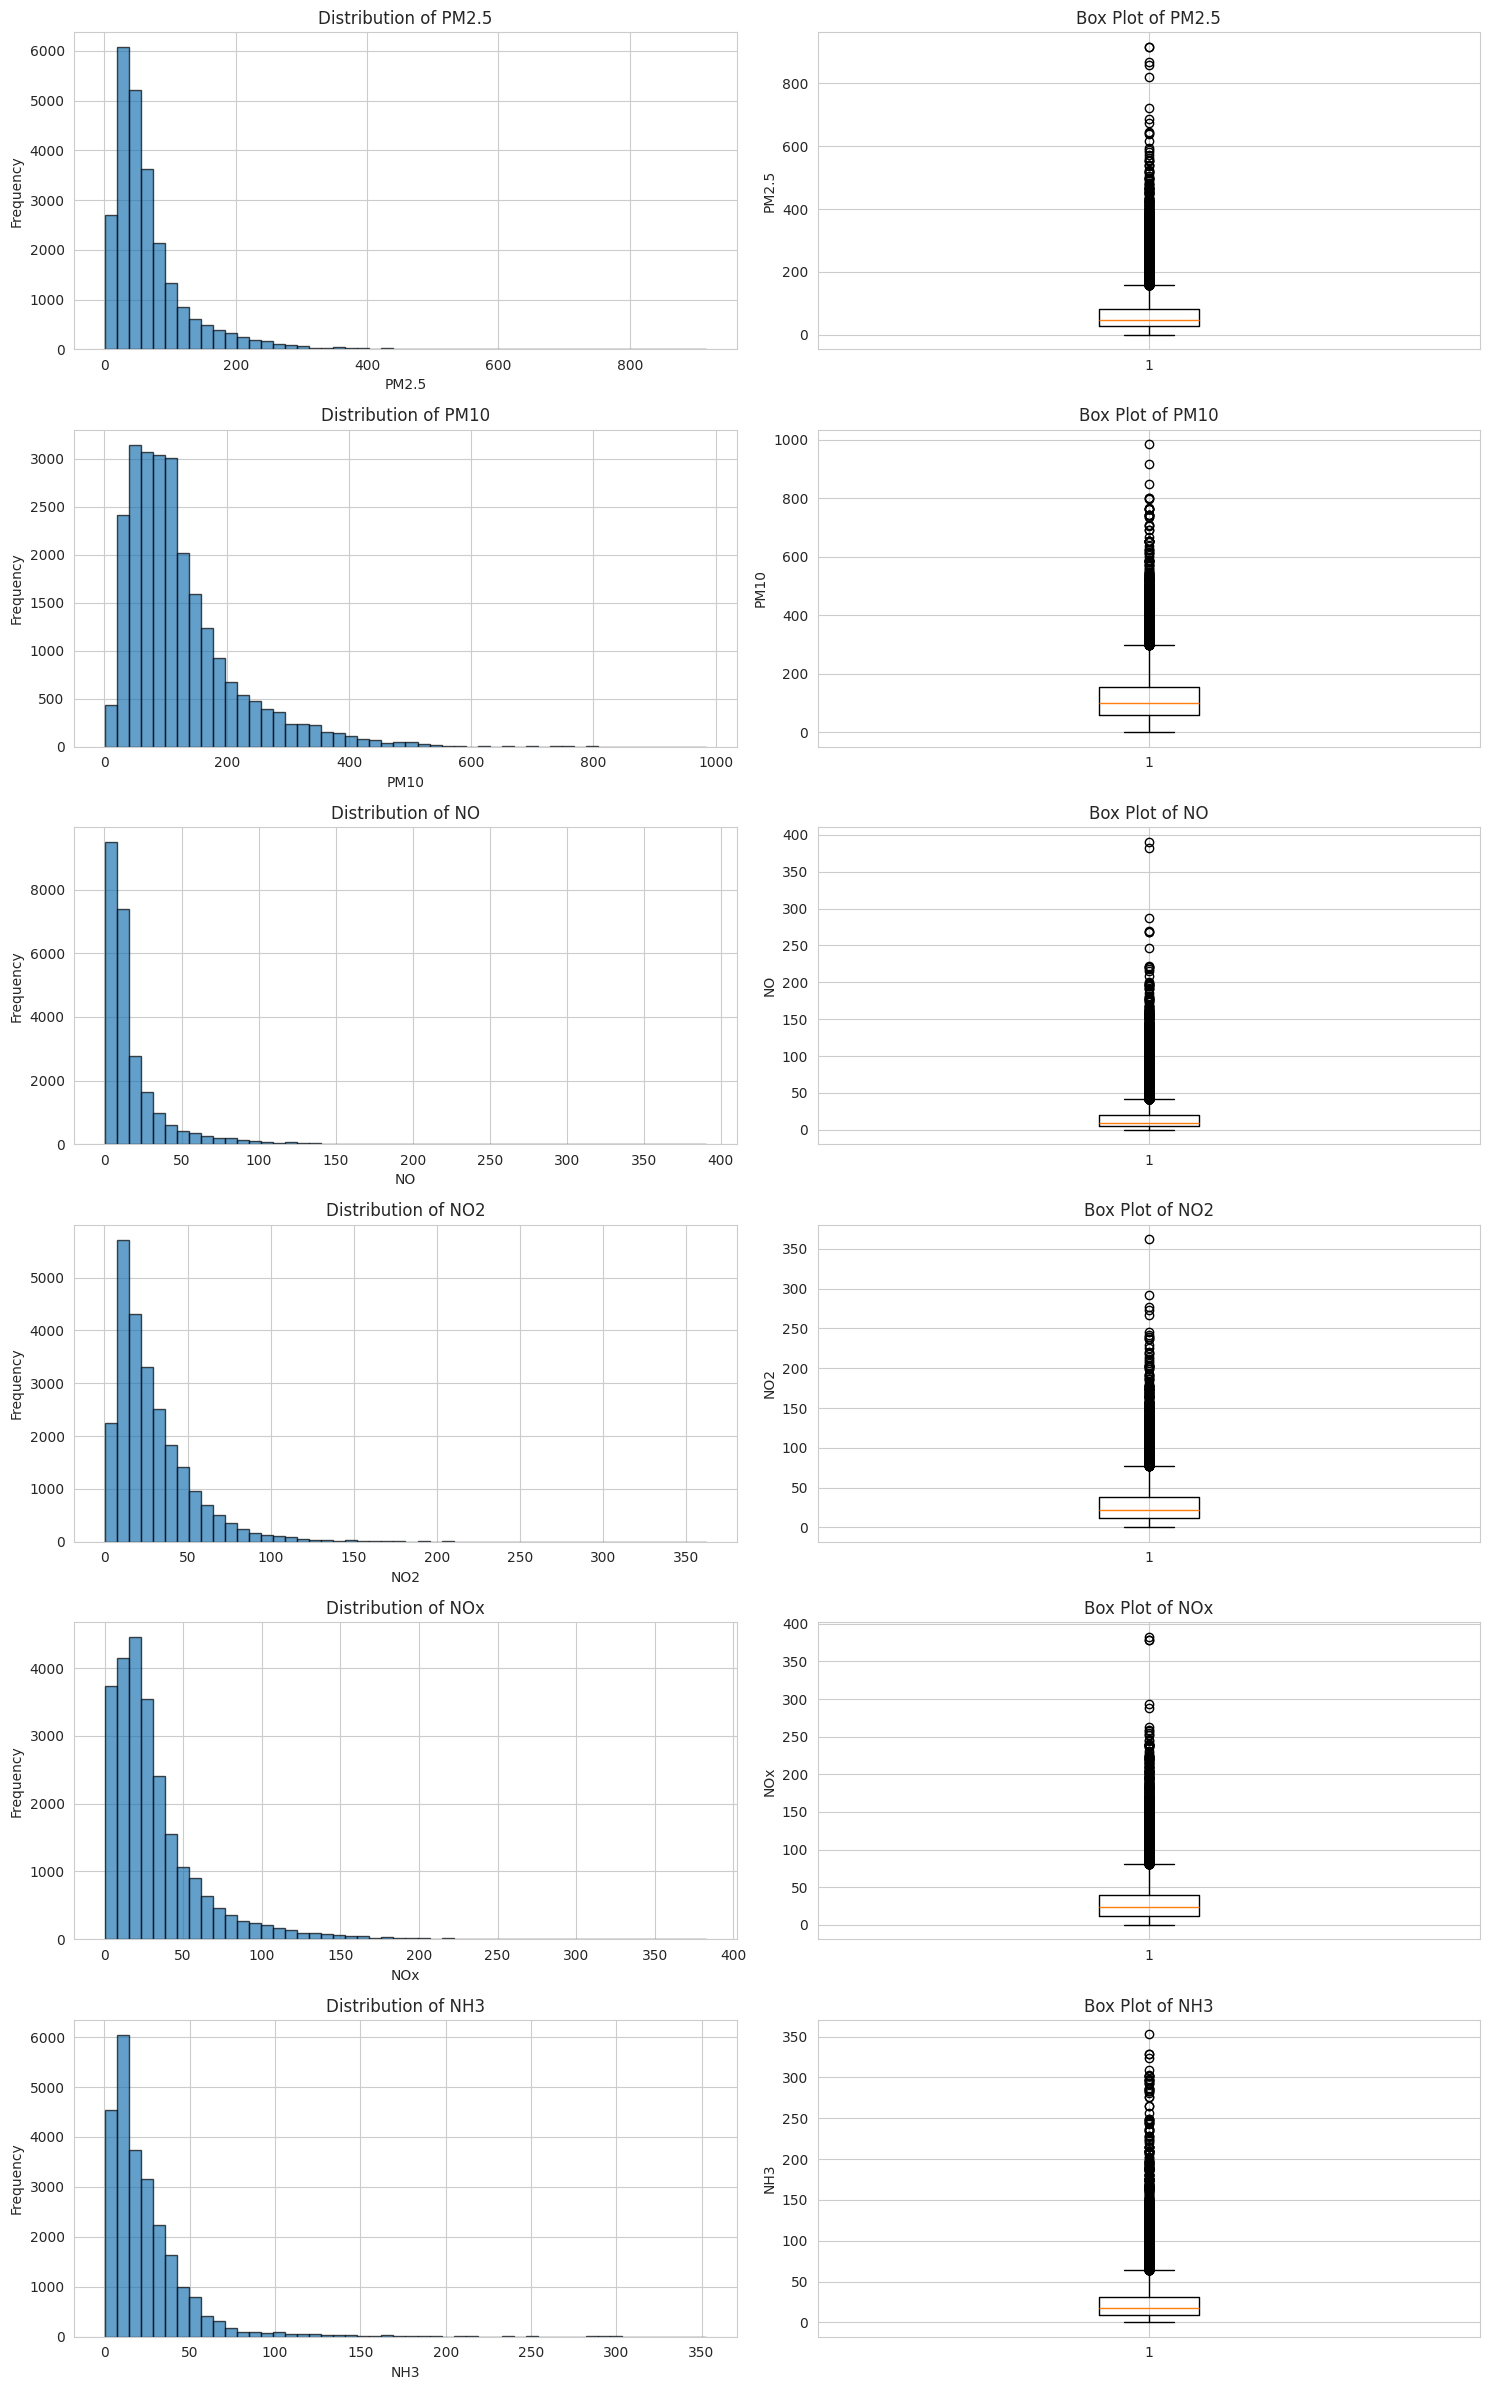

Distribution analysis completed and saved!


In [ ]:
print("="*60)
print("EXPLORATORY DATA ANALYSIS")
print("="*60)

# Select numeric columns for analysis
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
pollutant_cols = [col for col in numeric_cols if col not in ['year', 'month', 'day', 'dayofweek', 'quarter', 'is_weekend']]

# Distribution plots
fig, axes = plt.subplots(len(pollutant_cols[:6]), 2, figsize=(15, 4*min(len(pollutant_cols[:6]), 6)))
if len(pollutant_cols) == 1:
    axes = axes.reshape(1, -1)

for idx, col in enumerate(pollutant_cols[:6]):
    # Histogram
    axes[idx, 0].hist(df_clean[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[idx, 0].set_title(f'Distribution of {col}')
    axes[idx, 0].set_xlabel(col)
    axes[idx, 0].set_ylabel('Frequency')

    # Box plot
    axes[idx, 1].boxplot(df_clean[col].dropna())
    axes[idx, 1].set_title(f'Box Plot of {col}')
    axes[idx, 1].set_ylabel(col)

plt.tight_layout()
plt.savefig('outputs/distribution_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Distribution analysis completed and saved!")

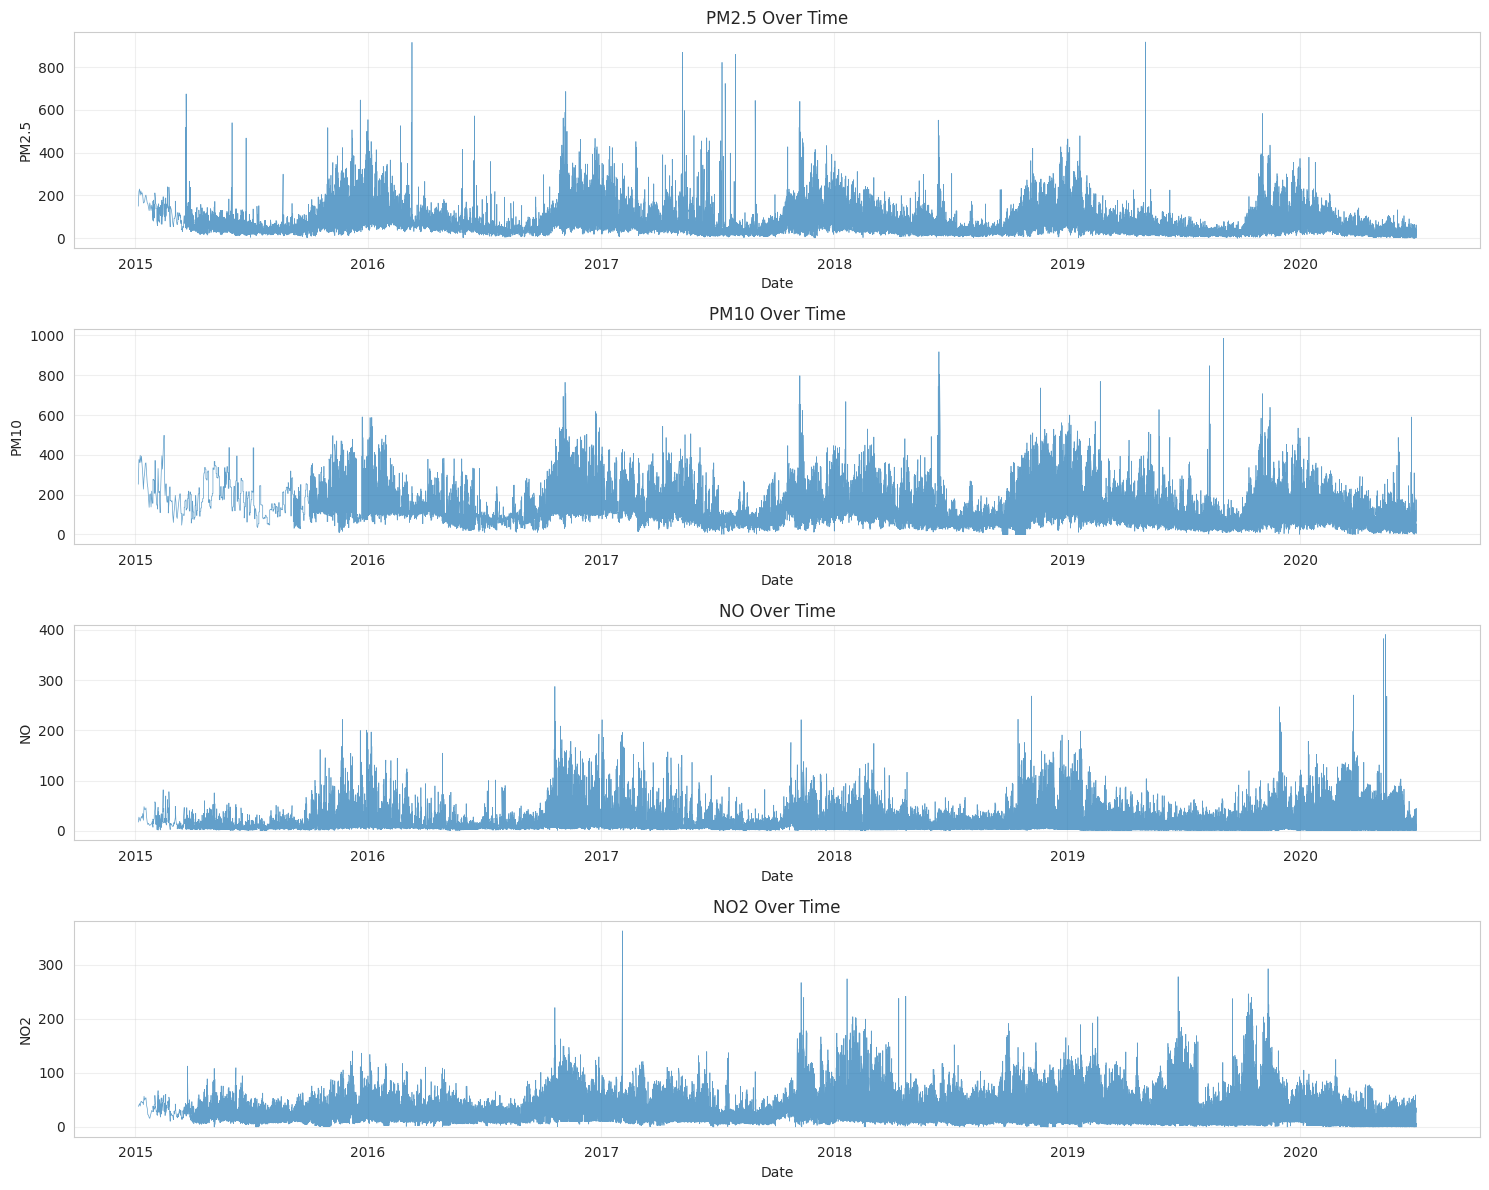

Time series analysis completed and saved!


In [ ]:
# Time series plots
fig, axes = plt.subplots(min(len(pollutant_cols[:4]), 4), 1, figsize=(15, 3*min(len(pollutant_cols[:4]), 4)))

if len(pollutant_cols) == 1:
    axes = [axes]

for idx, col in enumerate(pollutant_cols[:4]):
    axes[idx].plot(df_clean[date_col], df_clean[col], linewidth=0.5, alpha=0.7)
    axes[idx].set_title(f'{col} Over Time')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel(col)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/time_series_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("Time series analysis completed and saved!")

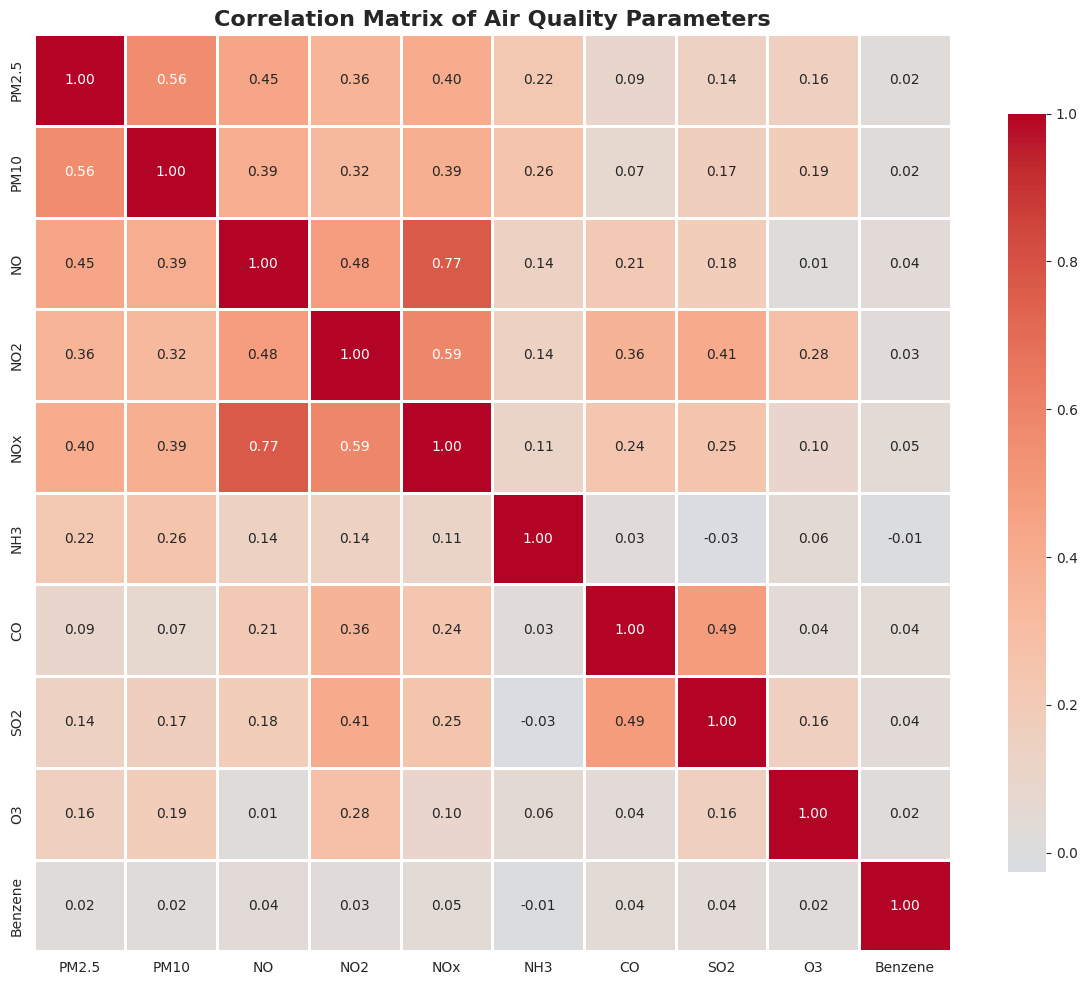

Correlation analysis completed and saved!

Highly correlated pairs (|correlation| > 0.7):
--------------------------------------------------
NO <-> NOx: 0.766


In [ ]:
# Correlation matrix
correlation_cols = pollutant_cols[:10]  # Limit to first 10 for readability
corr_matrix = df_clean[correlation_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Air Quality Parameters', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Correlation analysis completed and saved!")
print("\nHighly correlated pairs (|correlation| > 0.7):")
print("-" * 50)
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            print(f"{corr_matrix.columns[i]} <-> {corr_matrix.columns[j]}: {corr_matrix.iloc[i, j]:.3f}")

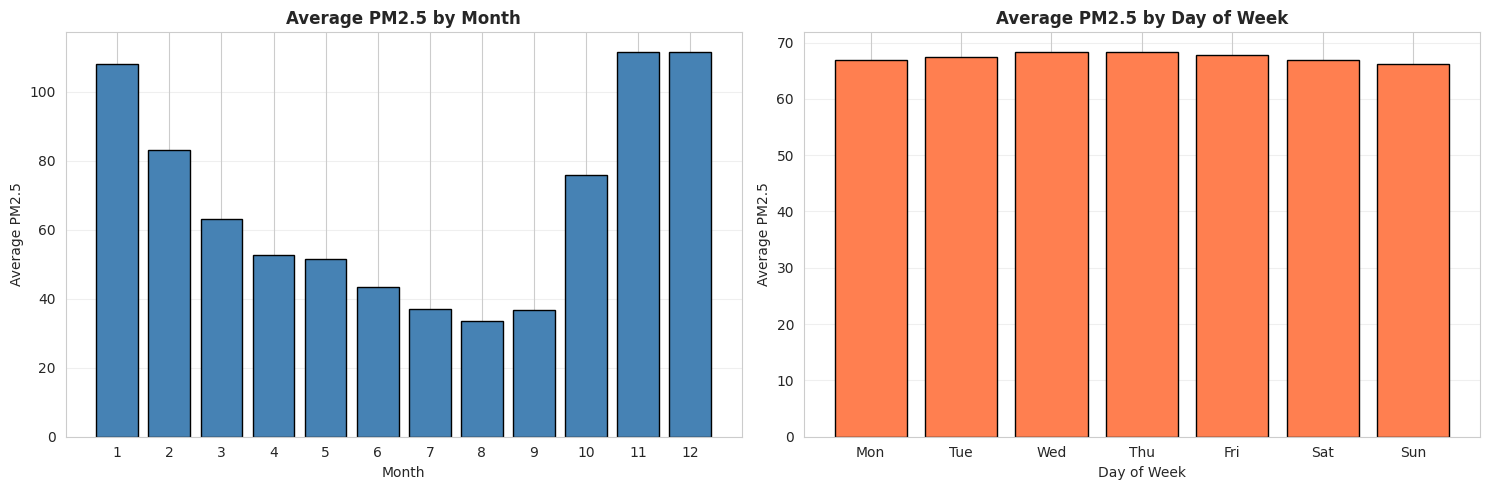

Seasonal pattern analysis completed and saved!


In [ ]:
# Monthly and seasonal patterns
if 'month' in df_clean.columns and len(pollutant_cols) > 0:
    target_col = pollutant_cols[0]  # Using first pollutant column

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Monthly average
    monthly_avg = df_clean.groupby('month')[target_col].mean()
    axes[0].bar(monthly_avg.index, monthly_avg.values, color='steelblue', edgecolor='black')
    axes[0].set_title(f'Average {target_col} by Month', fontweight='bold')
    axes[0].set_xlabel('Month')
    axes[0].set_ylabel(f'Average {target_col}')
    axes[0].set_xticks(range(1, 13))
    axes[0].grid(axis='y', alpha=0.3)

    # Day of week pattern
    dow_avg = df_clean.groupby('dayofweek')[target_col].mean()
    day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    axes[1].bar(range(7), dow_avg.values, color='coral', edgecolor='black')
    axes[1].set_title(f'Average {target_col} by Day of Week', fontweight='bold')
    axes[1].set_xlabel('Day of Week')
    axes[1].set_ylabel(f'Average {target_col}')
    axes[1].set_xticks(range(7))
    axes[1].set_xticklabels(day_names)
    axes[1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('outputs/seasonal_patterns.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Seasonal pattern analysis completed and saved!")

# Data Modeling and Training

In [ ]:
print("="*60)
print("PREPARING DATA FOR MODELING")
print("="*60)

# Identify target variable (AQI or primary pollutant)
aqi_cols = [col for col in df_clean.columns if 'aqi' in col.lower()]
if aqi_cols:
    target_col = aqi_cols[0]
else:
    target_col = pollutant_cols[0]

print(f"\nTarget variable: {target_col}")

# Select features (exclude date and target)
feature_cols = [col for col in df_clean.columns if col not in [date_col, target_col]
                and not col.startswith(target_col)]

print(f"Number of features: {len(feature_cols)}")
print(f"Features: {feature_cols[:10]}..." if len(feature_cols) > 10 else f"Features: {feature_cols}")

# Prepare data
X = df_clean[feature_cols]
y = df_clean[target_col]
dates = df_clean[date_col]

print(f"\nData shape:")
print(f"  X: {X.shape}")
print(f"  y: {y.shape}")

PREPARING DATA FOR MODELING

Target variable: AQI
Number of features: 19
Features: ['City', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']...

Data shape:
  X: (24845, 19)
  y: (24845,)


**Splitting dataset into 80/20 ratio**

In [ ]:
# Split data (80-20 split, maintaining time order)
split_index = int(len(df_clean) * 0.8)

X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]
dates_train = dates[:split_index]
dates_test = dates[split_index:]

print("="*60)
print("TRAIN-TEST SPLIT")
print("="*60)
print(f"\nTraining set:")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  Date range: {dates_train.min()} to {dates_train.max()}")

print(f"\nTest set:")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")
print(f"  Date range: {dates_test.min()} to {dates_test.max()}")

print(f"\nTrain-Test ratio: {len(X_train)/len(X)*100:.1f}% - {len(X_test)/len(X)*100:.1f}%")

TRAIN-TEST SPLIT

Training set:
  X_train shape: (19876, 19)
  y_train shape: (19876,)
  Date range: 2015-01-06 00:00:00 to 2019-12-06 00:00:00

Test set:
  X_test shape: (4969, 19)
  y_test shape: (4969,)
  Date range: 2019-12-06 00:00:00 to 2020-07-01 00:00:00

Train-Test ratio: 80.0% - 20.0%


**ARIMA Model**

In [ ]:
print("="*60)
print("MODEL 1: ARIMA")
print("="*60)

# Train ARIMA model
print("\nTraining ARIMA model...")
print("This may take a few minutes...")

try:
    # Use auto ARIMA parameters (p=1, d=1, q=1) - can be tuned
    arima_model = ARIMA(y_train, order=(1, 1, 1))
    arima_fitted = arima_model.fit()

    print("ARIMA model trained successfully!")
    print(arima_fitted.summary())

    # Make predictions
    arima_train_pred = arima_fitted.fittedvalues
    arima_test_pred = arima_fitted.forecast(steps=len(y_test))

    # Calculate metrics
    arima_train_mae = mean_absolute_error(y_train[1:], arima_train_pred[1:])  # Skip first value
    arima_train_rmse = np.sqrt(mean_squared_error(y_train[1:], arima_train_pred[1:]))
    arima_test_mae = mean_absolute_error(y_test, arima_test_pred)
    arima_test_rmse = np.sqrt(mean_squared_error(y_test, arima_test_pred))

    print(f"\nARIMA Performance:")
    print(f"  Train MAE: {arima_train_mae:.4f}")
    print(f"  Train RMSE: {arima_train_rmse:.4f}")
    print(f"  Test MAE: {arima_test_mae:.4f}")
    print(f"  Test RMSE: {arima_test_rmse:.4f}")

    # Store results
    arima_results = {
        'model': arima_fitted,
        'train_predictions': arima_train_pred,
        'test_predictions': arima_test_pred,
        'train_mae': arima_train_mae,
        'train_rmse': arima_train_rmse,
        'test_mae': arima_test_mae,
        'test_rmse': arima_test_rmse
    }

except Exception as e:
    print(f"Error training ARIMA: {str(e)}")
    arima_results = None

MODEL 1: ARIMA

Training ARIMA model...
This may take a few minutes...
ARIMA model trained successfully!
                               SARIMAX Results                                
Dep. Variable:                    AQI   No. Observations:                19876
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -126020.690
Date:                Mon, 27 Oct 2025   AIC                         252047.381
Time:                        02:55:25   BIC                         252071.073
Sample:                             0   HQIC                        252055.134
                              - 19876                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0507      0.008     -6.514      0.000      -0.066      -0.035
ma.L1         -0.9793     

**Prophet Model**

In [ ]:
print("="*60)
print("MODEL 2: PROPHET")
print("="*60)

# Prepare data for Prophet
prophet_train = pd.DataFrame({
    'ds': dates_train.values,
    'y': y_train.values
})

prophet_test = pd.DataFrame({
    'ds': dates_test.values,
    'y': y_test.values
})

print("\nTraining Prophet model...")

try:
    # Initialize and train Prophet
    prophet_model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=True,
        seasonality_mode='multiplicative'
    )

    prophet_model.fit(prophet_train)

    print("Prophet model trained successfully!")

    # Make predictions
    prophet_train_forecast = prophet_model.predict(prophet_train)
    prophet_test_forecast = prophet_model.predict(prophet_test)

    prophet_train_pred = prophet_train_forecast['yhat'].values
    prophet_test_pred = prophet_test_forecast['yhat'].values

    # Calculate metrics
    prophet_train_mae = mean_absolute_error(y_train, prophet_train_pred)
    prophet_train_rmse = np.sqrt(mean_squared_error(y_train, prophet_train_pred))
    prophet_test_mae = mean_absolute_error(y_test, prophet_test_pred)
    prophet_test_rmse = np.sqrt(mean_squared_error(y_test, prophet_test_pred))

    print(f"\nProphet Performance:")
    print(f"  Train MAE: {prophet_train_mae:.4f}")
    print(f"  Train RMSE: {prophet_train_rmse:.4f}")
    print(f"  Test MAE: {prophet_test_mae:.4f}")
    print(f"  Test RMSE: {prophet_test_rmse:.4f}")

    # Store results
    prophet_results = {
        'model': prophet_model,
        'train_predictions': prophet_train_pred,
        'test_predictions': prophet_test_pred,
        'train_mae': prophet_train_mae,
        'train_rmse': prophet_train_rmse,
        'test_mae': prophet_test_mae,
        'test_rmse': prophet_test_rmse
    }

except Exception as e:
    print(f"Error training Prophet: {str(e)}")
    prophet_results = None

MODEL 2: PROPHET

Training Prophet model...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpff_no1tc/9liqfrzm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpff_no1tc/l_gp8vur.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39384', 'data', 'file=/tmp/tmpff_no1tc/9liqfrzm.json', 'init=/tmp/tmpff_no1tc/l_gp8vur.json', 'output', 'file=/tmp/tmpff_no1tc/prophet_model28nzfy06/prophet_model-20251027025550.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:55:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:55:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet model trained successfully!

Prophet Performance:
  Train MAE: 87.7064
  Train RMSE: 137.1423
  Test MAE: 54.0726
  Test RMSE: 80.5688



**LSTM Model**

In [ ]:
print("="*60)
print("MODEL 3: LSTM (Deep Learning)")
print("="*60)

# Prepare data for LSTM
print("\nPreparing data for LSTM...")

# IMPORTANT: Select only numeric columns for LSTM
print("\nFiltering numeric columns only...")
numeric_feature_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numeric features: {len(numeric_feature_cols)} out of {len(X_train.columns)}")

# Filter to numeric columns only
X_train_numeric = X_train[numeric_feature_cols]
X_test_numeric = X_test[numeric_feature_cols]

print(f"X_train shape after filtering: {X_train_numeric.shape}")
print(f"X_test shape after filtering: {X_test_numeric.shape}")

# Check for any remaining non-numeric or infinite values
if X_train_numeric.isnull().any().any():
    print("Warning: Found NaN values, filling with median...")
    X_train_numeric = X_train_numeric.fillna(X_train_numeric.median())
    X_test_numeric = X_test_numeric.fillna(X_train_numeric.median())

# Replace infinite values
X_train_numeric = X_train_numeric.replace([np.inf, -np.inf], np.nan)
X_test_numeric = X_test_numeric.replace([np.inf, -np.inf], np.nan)
X_train_numeric = X_train_numeric.fillna(X_train_numeric.median())
X_test_numeric = X_test_numeric.fillna(X_train_numeric.median())

# Scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train_numeric)
X_test_scaled = scaler_X.transform(X_test_numeric)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape for LSTM [samples, time steps, features]
# Using 1 time step for simplicity
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print(f"\nLSTM input shape: {X_train_lstm.shape}")
print(f"Data scaled and reshaped successfully!")

#-----LSTM Training---------
# Build LSTM model
print("\nBuilding LSTM model...")

lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(1, X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print(lstm_model.summary())

# Train LSTM
print("\nTraining LSTM model...")
print("This may take several minutes...")

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = lstm_model.fit(
    X_train_lstm, y_train_scaled,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

print("LSTM model trained successfully!")

# Make predictions
lstm_train_pred_scaled = lstm_model.predict(X_train_lstm)
lstm_test_pred_scaled = lstm_model.predict(X_test_lstm)

# Inverse transform predictions
lstm_train_pred = scaler_y.inverse_transform(lstm_train_pred_scaled).flatten()
lstm_test_pred = scaler_y.inverse_transform(lstm_test_pred_scaled).flatten()

# Calculate metrics
lstm_train_mae = mean_absolute_error(y_train, lstm_train_pred)
lstm_train_rmse = np.sqrt(mean_squared_error(y_train, lstm_train_pred))
lstm_test_mae = mean_absolute_error(y_test, lstm_test_pred)
lstm_test_rmse = np.sqrt(mean_squared_error(y_test, lstm_test_pred))

print(f"\nLSTM Performance:")
print(f"  Train MAE: {lstm_train_mae:.4f}")
print(f"  Train RMSE: {lstm_train_rmse:.4f}")
print(f"  Test MAE: {lstm_test_mae:.4f}")
print(f"  Test RMSE: {lstm_test_rmse:.4f}")

# Store results
lstm_results = {
    'model': lstm_model,
    'scaler_X': scaler_X,
    'scaler_y': scaler_y,
    'train_predictions': lstm_train_pred,
    'test_predictions': lstm_test_pred,
    'train_mae': lstm_train_mae,
    'train_rmse': lstm_train_rmse,
    'test_mae': lstm_test_mae,
    'test_rmse': lstm_test_rmse,
    'history': history,
    'numeric_features': numeric_feature_cols  # Store for inference
}

print("\n✓ LSTM results stored successfully!")

MODEL 3: LSTM (Deep Learning)

Preparing data for LSTM...

Filtering numeric columns only...
Numeric features: 18 out of 19
X_train shape after filtering: (19876, 18)
X_test shape after filtering: (4969, 18)

LSTM input shape: (19876, 1, 18)
Data scaled and reshaped successfully!

Building LSTM model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 50)          │        13,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,301 (137.89 KB)

 Trainable params: 35,301 (137.89 KB)

 Non-trainable params: 0 (0.00 B)

None

Training LSTM model...
This may take several minutes...
Epoch 1/50
497/497 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0046 - mae: 0.0432 - val_loss: 9.0918e-04 - val_mae: 0.0182
Epoch 2/50
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0017 - mae: 0.0254 - val_loss: 4.7307e-04 - val_mae: 0.0134
Epoch 3/50
497/497 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0014 - mae: 0.0226 - val_loss: 4.1679e-04 - val_mae: 0.0124
Epoch 4/50
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0012 - mae: 0.0206 - val_loss: 4.2958e-04 - val_mae: 0.0122
Epoch 5/50
497/497 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0011 - mae: 0.0197 - val_loss: 3.9399e-04 - val_mae: 0.0116
Epoch 6/50
497/497 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0010 - mae: 0.0188 - val_loss: 3.7893e-04 - val_mae: 0.0116
Epoch 7/50
497/497 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0011 - mae: 0.0189 - val_loss: 4.5171e-04 - val_mae: 0.0142
Epoch 8/50
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0010 - mae: 0.0187 - v

**XGBoost Model**

In [ ]:
print("="*60)
print("MODEL 4: XGBOOST")
print("="*60)

print("\nTraining XGBoost model...")

# Filter to numeric columns only (XGBoost needs numeric data)
numeric_feature_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
X_train_numeric = X_train[numeric_feature_cols]
X_test_numeric = X_test[numeric_feature_cols]

# Handle any missing values
X_train_numeric = X_train_numeric.fillna(X_train_numeric.median())
X_test_numeric = X_test_numeric.fillna(X_train_numeric.median())

# Train XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train_numeric, y_train)

print("XGBoost model trained successfully!")

# Make predictions
xgb_train_pred = xgb_model.predict(X_train_numeric)
xgb_test_pred = xgb_model.predict(X_test_numeric)

# Calculate metrics
xgb_train_mae = mean_absolute_error(y_train, xgb_train_pred)
xgb_train_rmse = np.sqrt(mean_squared_error(y_train, xgb_train_pred))
xgb_test_mae = mean_absolute_error(y_test, xgb_test_pred)
xgb_test_rmse = np.sqrt(mean_squared_error(y_test, xgb_test_pred))

print(f"\nXGBoost Performance:")
print(f"  Train MAE: {xgb_train_mae:.4f}")
print(f"  Train RMSE: {xgb_train_rmse:.4f}")
print(f"  Test MAE: {xgb_test_mae:.4f}")
print(f"  Test RMSE: {xgb_test_rmse:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': numeric_feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Store results
xgb_results = {
    'model': xgb_model,
    'train_predictions': xgb_train_pred,
    'test_predictions': xgb_test_pred,
    'train_mae': xgb_train_mae,
    'train_rmse': xgb_train_rmse,
    'test_mae': xgb_test_mae,
    'test_rmse': xgb_test_rmse,
    'feature_importance': feature_importance,
    'numeric_features': numeric_feature_cols  # Store for inference
}

print("\n✓ XGBoost results stored successfully!")

MODEL 4: XGBOOST

Training XGBoost model...
XGBoost model trained successfully!

XGBoost Performance:
  Train MAE: 21.1870
  Train RMSE: 35.2113
  Test MAE: 17.3415
  Test RMSE: 29.3430

Top 10 Important Features:
feature  importance
  PM2.5    0.403268
     CO    0.341639
     NO    0.082653
   PM10    0.025774
     O3    0.018494
    NOx    0.017199
    NO2    0.015405
    day    0.013726
Toluene    0.012836
    SO2    0.012093

✓ XGBoost results stored successfully!


**All Models - Forecast**

ALL MODELS - FORECAST PLOTS


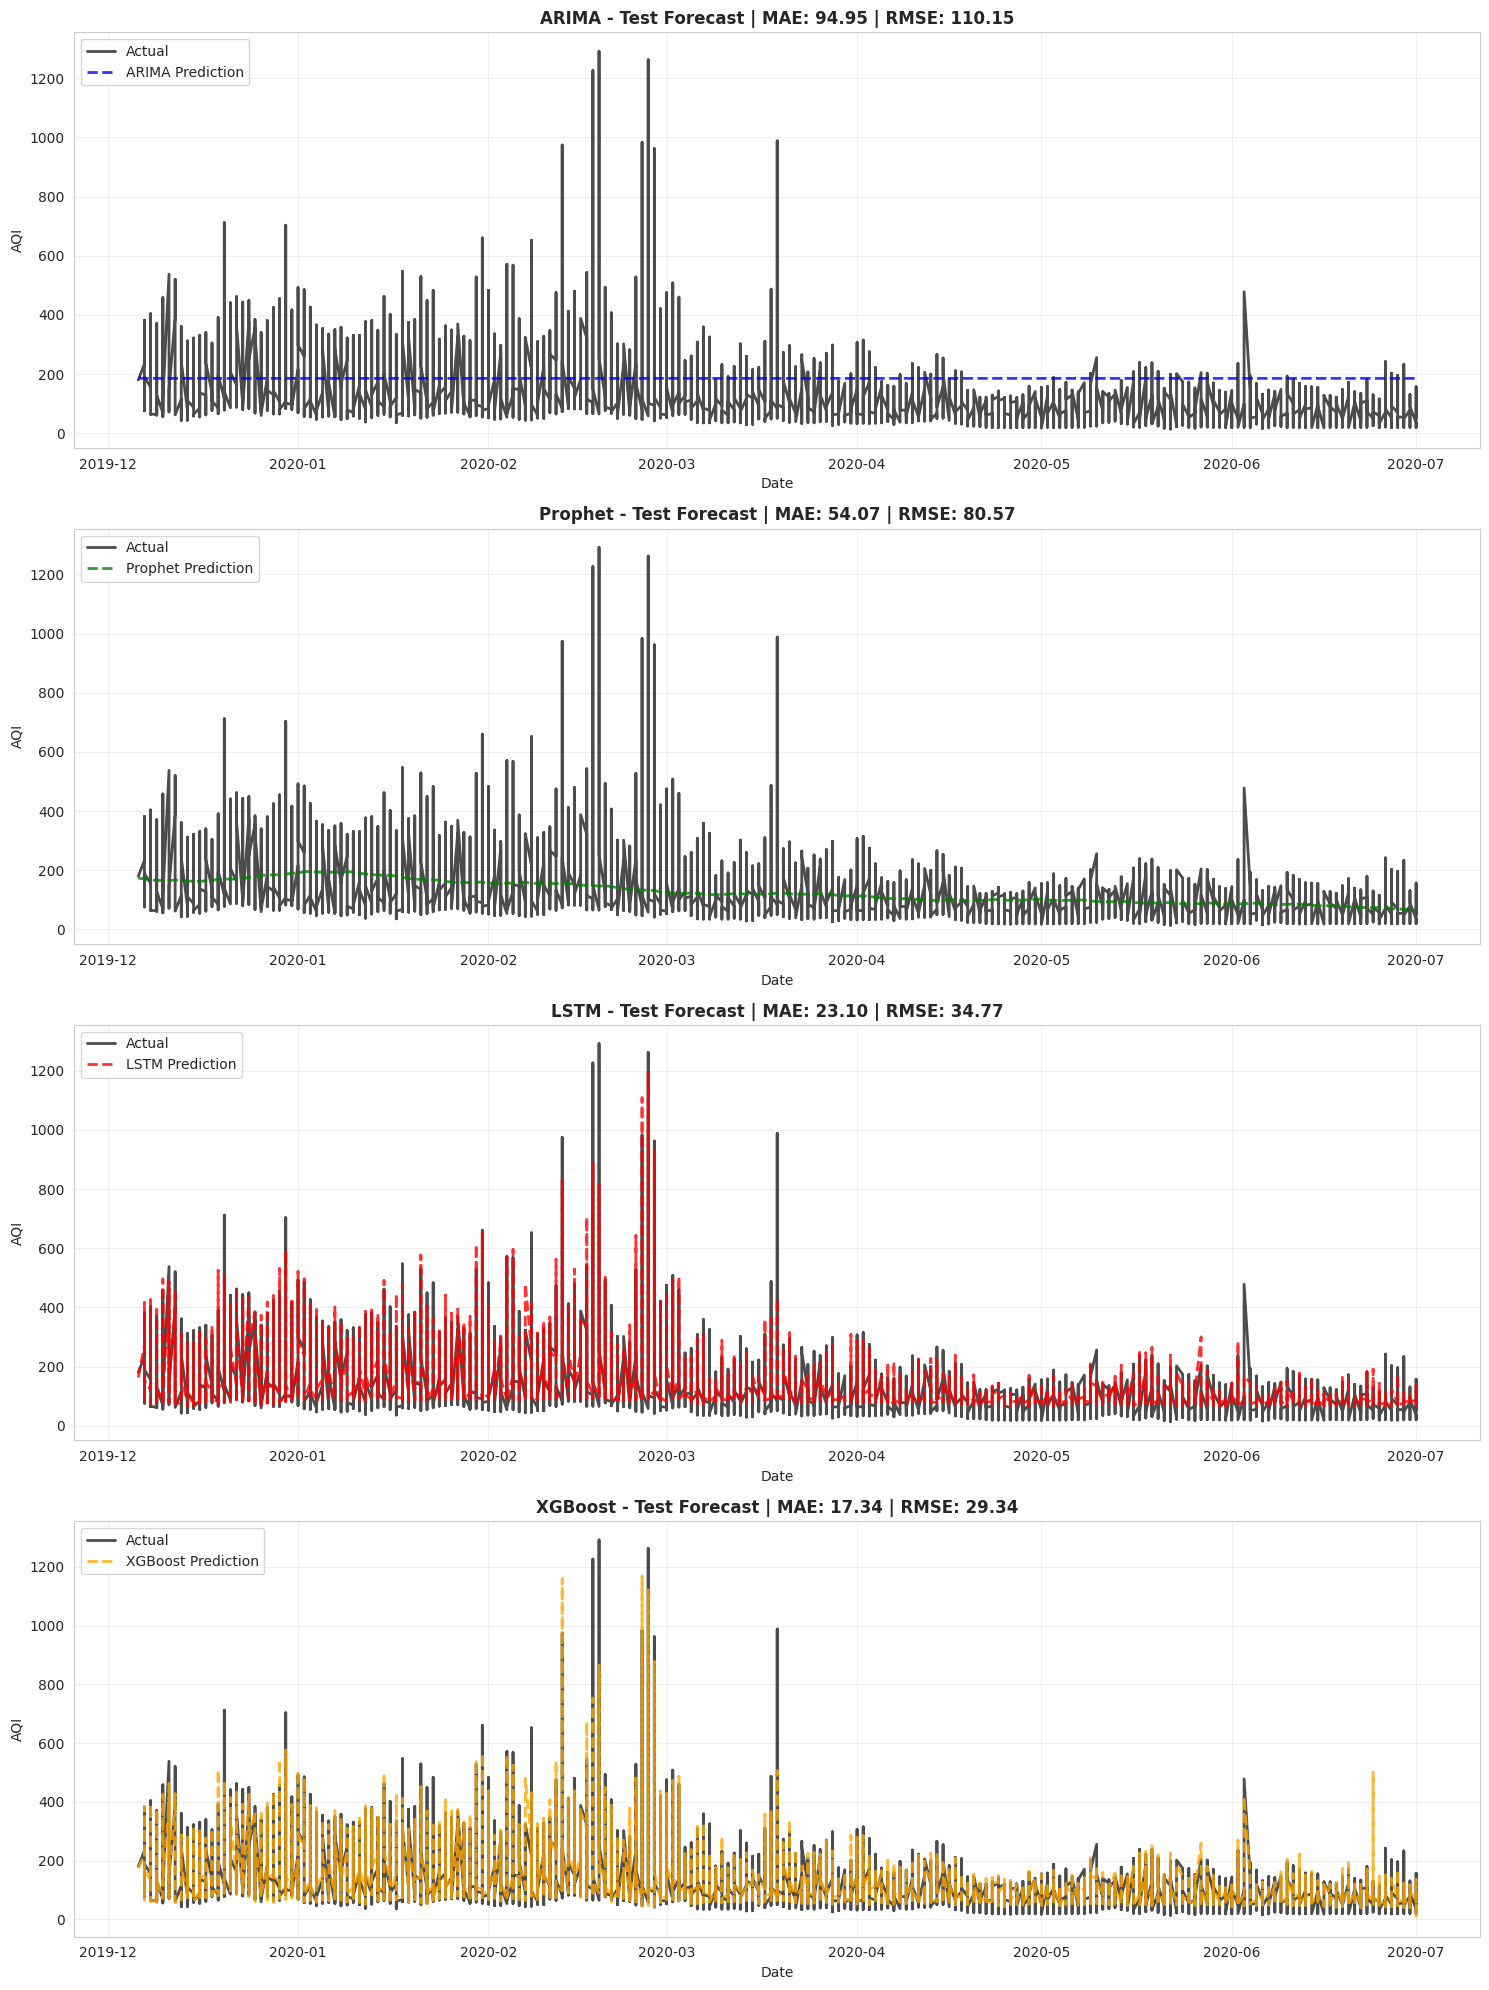

✓ All model forecasts plotted and saved!


In [ ]:
print("="*60)
print("ALL MODELS - FORECAST PLOTS")
print("="*60)

# Prepare models list
models_list = []
if arima_results:
    models_list.append(('ARIMA', arima_results, 'blue'))
if prophet_results:
    models_list.append(('Prophet', prophet_results, 'green'))
if lstm_results:
    models_list.append(('LSTM', lstm_results, 'red'))
if xgb_results:
    models_list.append(('XGBoost', xgb_results, 'orange'))

# Create subplots
fig, axes = plt.subplots(len(models_list), 1, figsize=(15, 5*len(models_list)))
if len(models_list) == 1:
    axes = [axes]

# Plot each model
for idx, (name, results, color) in enumerate(models_list):
    axes[idx].plot(dates_test, y_test, label='Actual', color='black', linewidth=2, alpha=0.7)
    axes[idx].plot(dates_test, results['test_predictions'], label=f'{name} Prediction',
                   color=color, linewidth=2, linestyle='--', alpha=0.8)
    axes[idx].set_title(f'{name} - Test Forecast | MAE: {results["test_mae"]:.2f} | RMSE: {results["test_rmse"]:.2f}',
                       fontweight='bold', fontsize=12)
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel(target_col)
    axes[idx].legend(loc='upper left')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/all_models_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ All model forecasts plotted and saved!")

**Comparison Plot**

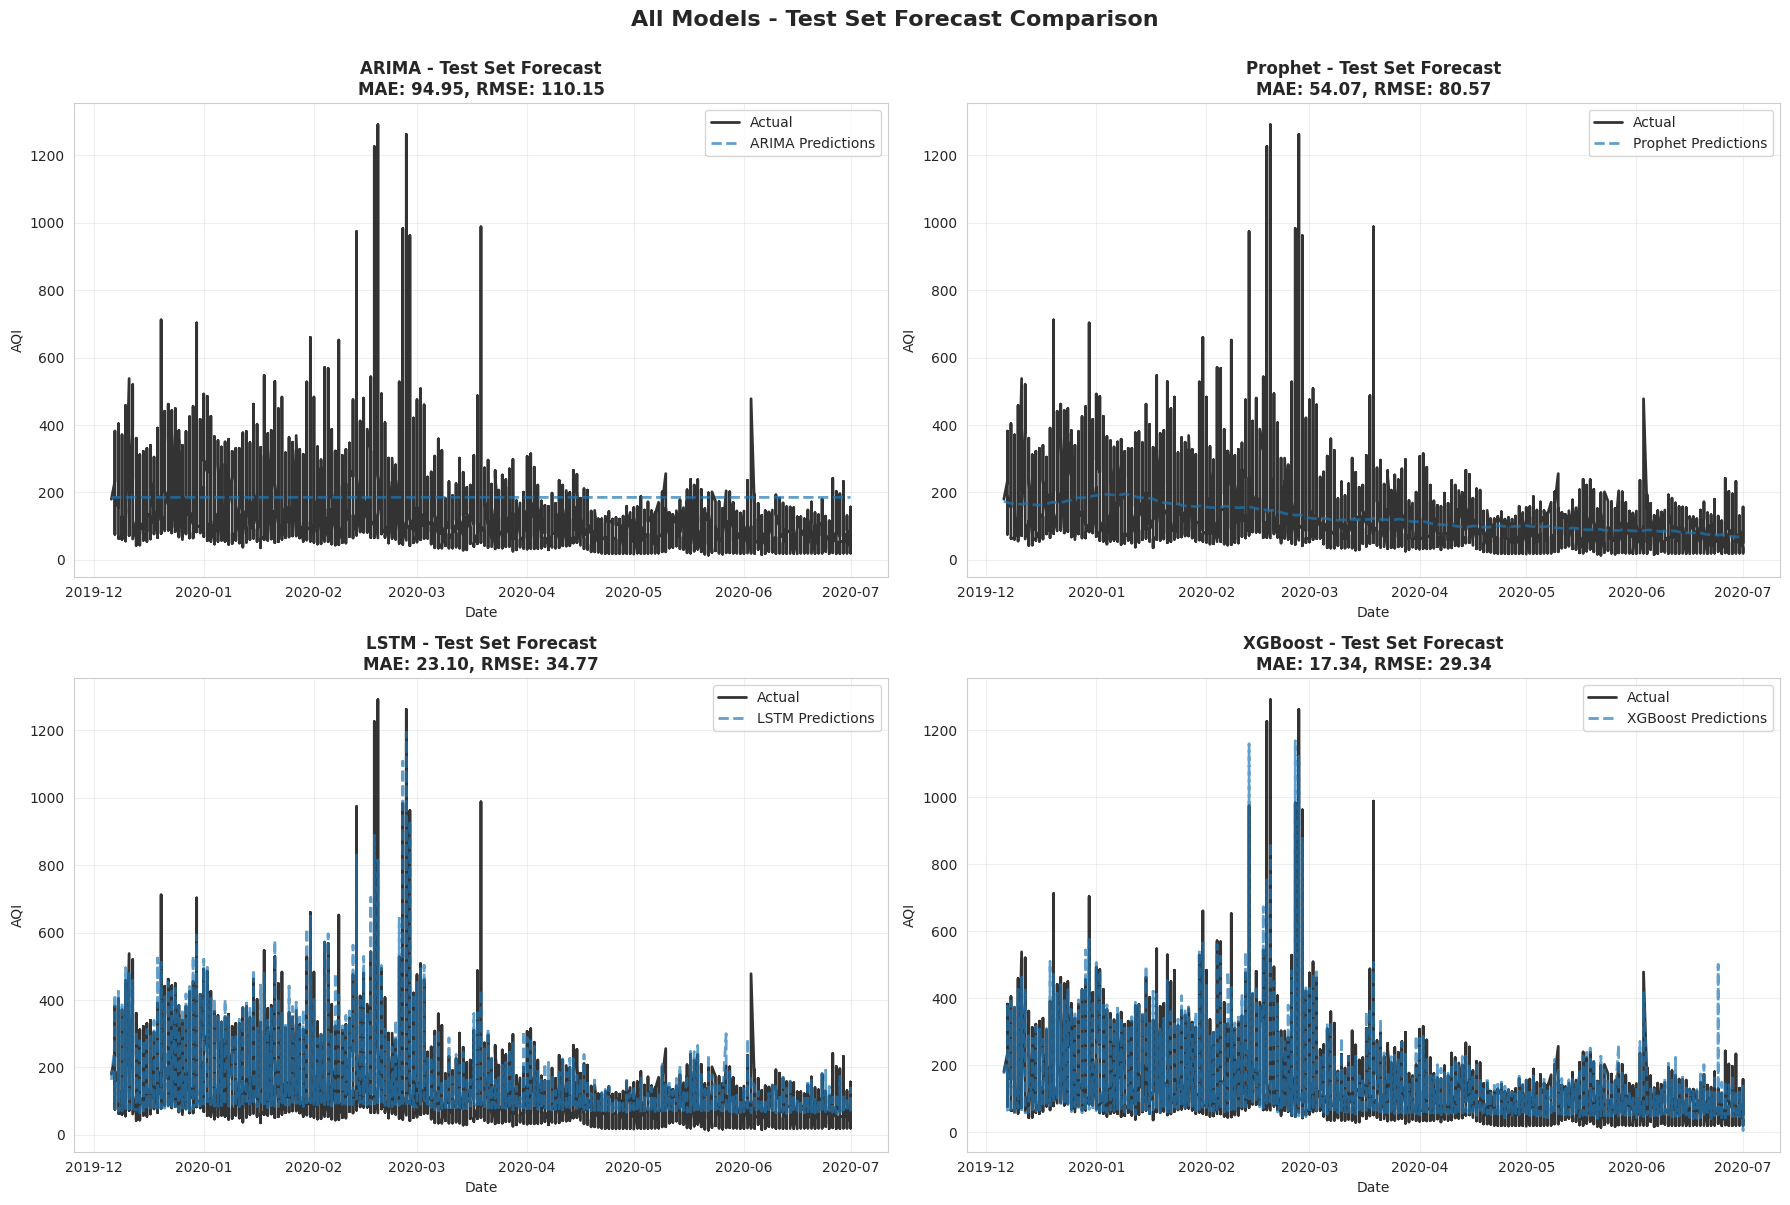

Combined forecast comparison plot saved!


In [ ]:
# Create comprehensive comparison plot
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

models_to_plot = []
if arima_results:
    models_to_plot.append(('ARIMA', arima_results))
if prophet_results:
    models_to_plot.append(('Prophet', prophet_results))
if lstm_results:
    models_to_plot.append(('LSTM', lstm_results))
if xgb_results:
    models_to_plot.append(('XGBoost', xgb_results))

for idx, (model_name, results) in enumerate(models_to_plot):
    row = idx // 2
    col = idx % 2

    axes[row, col].plot(dates_test, y_test, label='Actual', linewidth=2, alpha=0.8, color='black')
    axes[row, col].plot(dates_test, results['test_predictions'],
                        label=f'{model_name} Predictions', linewidth=2, alpha=0.7, linestyle='--')
    axes[row, col].set_title(f'{model_name} - Test Set Forecast\nMAE: {results["test_mae"]:.2f}, RMSE: {results["test_rmse"]:.2f}',
                             fontweight='bold', fontsize=12)
    axes[row, col].set_xlabel('Date')
    axes[row, col].set_ylabel(target_col)
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.suptitle('All Models - Test Set Forecast Comparison', fontweight='bold', fontsize=16, y=1.00)
plt.tight_layout()
plt.savefig('outputs/all_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Combined forecast comparison plot saved!")

**Saving the best Model**

In [ ]:
print("="*60)
print("SAVING BEST MODEL")
print("="*60)

# Determine best model
best_model_dict = {
    'ARIMA': arima_results if arima_results else None,
    'Prophet': prophet_results if prophet_results else None,
    'LSTM': lstm_results if lstm_results else None,
    'XGBoost': xgb_results if xgb_results else None
}

# Get best model based on test MAE
test_maes = {}
for name, results in best_model_dict.items():
    if results:
        test_maes[name] = results['test_mae']

best_model_name = min(test_maes, key=test_maes.get)
best_model_results = best_model_dict[best_model_name]

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test MAE: {best_model_results['test_mae']:.4f}")
print(f"   Test RMSE: {best_model_results['test_rmse']:.4f}")

# Save the best model
if best_model_name == 'ARIMA':
    # Save ARIMA using pickle
    with open('models/best_model_arima.pkl', 'wb') as f:
        pickle.dump(best_model_results['model'], f)
    print(f"\n✓ ARIMA model saved to 'models/best_model_arima.pkl'")

elif best_model_name == 'Prophet':
    # Save Prophet using pickle
    with open('models/best_model_prophet.pkl', 'wb') as f:
        pickle.dump(best_model_results['model'], f)
    print(f"\n✓ Prophet model saved to 'models/best_model_prophet.pkl'")

elif best_model_name == 'LSTM':
    # Save LSTM model and scalers
    best_model_results['model'].save('models/best_model_lstm.h5')
    joblib.dump(best_model_results['scaler_X'], 'models/lstm_scaler_X.pkl')
    joblib.dump(best_model_results['scaler_y'], 'models/lstm_scaler_y.pkl')
    print(f"\n✓ LSTM model saved to 'models/best_model_lstm.h5'")
    print(f"✓ Scalers saved to 'models/lstm_scaler_X.pkl' and 'models/lstm_scaler_y.pkl'")

elif best_model_name == 'XGBoost':
    # Save XGBoost using joblib
    joblib.dump(best_model_results['model'], 'models/best_model_xgboost.pkl')
    print(f"\n✓ XGBoost model saved to 'models/best_model_xgboost.pkl'")

# Save model metadata
model_metadata = {
    'best_model': best_model_name,
    'test_mae': best_model_results['test_mae'],
    'test_rmse': best_model_results['test_rmse'],
    'train_mae': best_model_results['train_mae'],
    'train_rmse': best_model_results['train_rmse'],
    'target_variable': target_col,
    'feature_columns': feature_cols,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('models/model_metadata.pkl', 'wb') as f:
    pickle.dump(model_metadata, f)

print("✓ Model metadata saved to 'models/model_metadata.pkl'")

SAVING BEST MODEL

🏆 Best Model: XGBoost
   Test MAE: 17.3415
   Test RMSE: 29.3430

✓ XGBoost model saved to 'models/best_model_xgboost.pkl'
✓ Model metadata saved to 'models/model_metadata.pkl'
